# 0. Problem Statement: 

* To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1. Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-08 21:45:50.205336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 21:45:50.227561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 21:45:50.227588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 21:45:50.228244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 21:45:50.232751: I tensorflow/core/platform/cpu_feature_guar

## 2. Create a dataset

Define some parameters for the loader:

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### 2.1 Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-05-08 21:46:00.222528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 21:46:00.249052: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualize the data
####  visualize one instance of all the nine classes present in the dataset

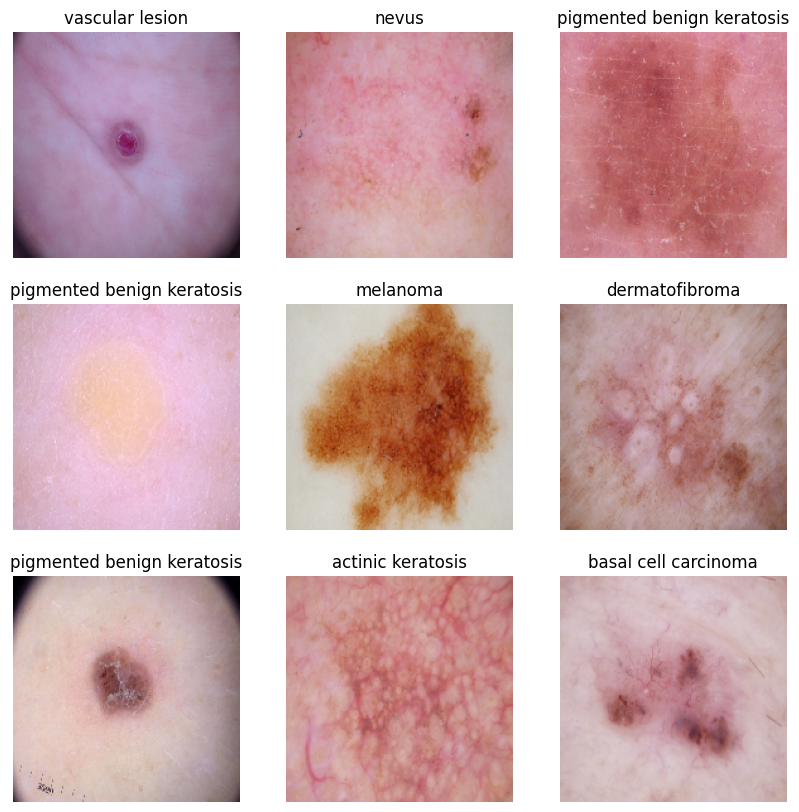

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Create the model
* Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### 4.1 Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 4.2 Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 64ms/step - loss: 2.0214 - accuracy: 0.2305 - val_loss: 1.8898 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 1.8246 - accuracy: 0.3354 - val_loss: 1.6795 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5698 - accuracy: 0.4671 - val_loss: 1.5779 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.3628 - accuracy: 0.5106 - val_loss: 1.5202 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.3088 - accuracy: 0.5273 - val_loss: 1.4082 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2323 - accuracy: 0.5642 - val_loss: 1.3932 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.1239 - accuracy: 0.5915 - val_loss: 1.4405 - val_accuracy: 0.5101
Epoch 8/20
56

### 4.3 Visualizing training results

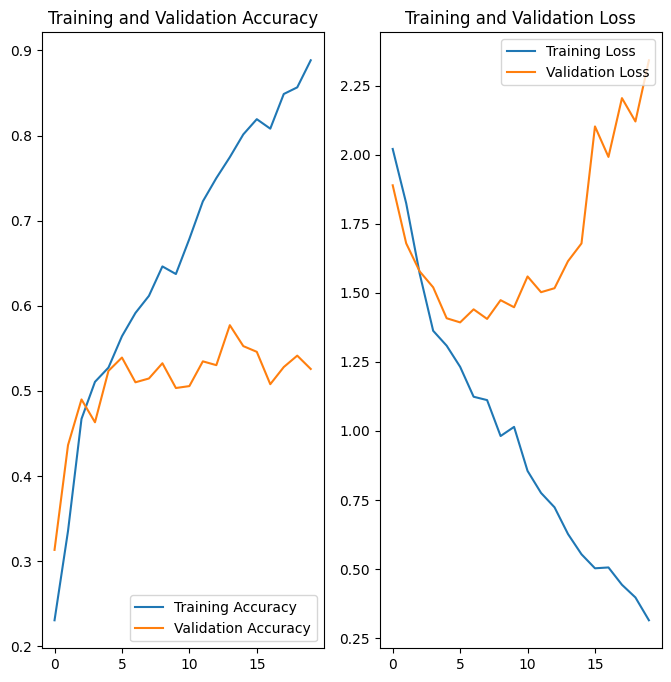

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


* The model seems to be overfitting in our first training. As you can see the training accuracy is around 88%.
* However our validation Accuracy is very less at just 52%.
* We can perform data augmentation to improve the score
* We can also add few dropout layers to reduce overfitting while training

## 5. Data Augumentation

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

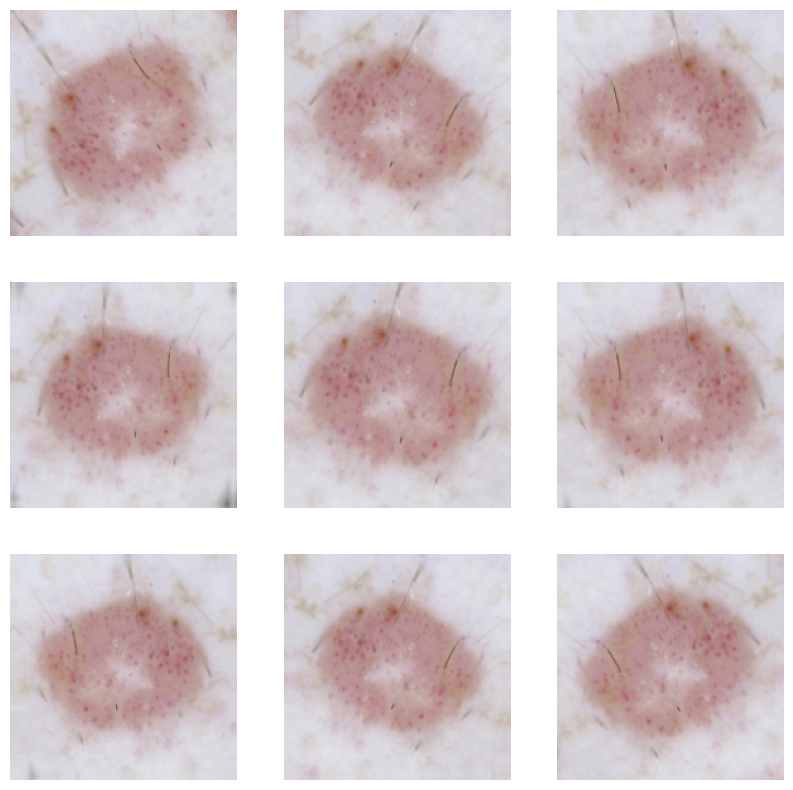

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 6. Model_2 : With Data Augmentation and dropout 


In [18]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### 6.1 Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 6.2 Training the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 71ms/step - loss: 1.9893 - accuracy: 0.2422 - val_loss: 1.8174 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 1.7077 - accuracy: 0.3834 - val_loss: 1.6286 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5362 - accuracy: 0.4559 - val_loss: 1.4719 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 4s 71ms/step - loss: 1.4366 - accuracy: 0.4715 - val_loss: 1.4730 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3892 - accuracy: 0.5134 - val_loss: 1.3984 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3693 - accuracy: 0.5190 - val_loss: 1.4880 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3171 - accuracy: 0.5307 - val_loss: 1.3340 - val_accuracy: 0.5190
Epoch 8/20
56

### 6.3 Visualizing the results

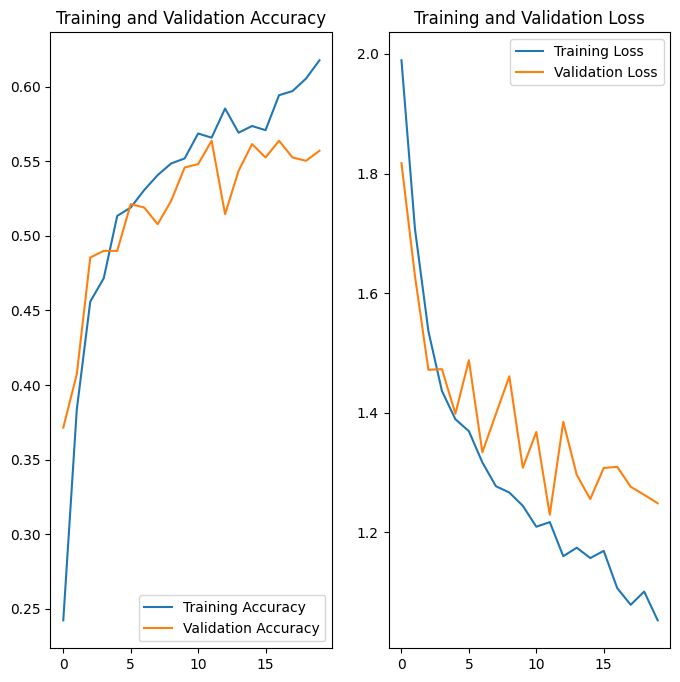

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We can see that adding data augmentation and dropout layers have resulted in less overfitting
* Training accuracy have come down to 61% while validation accuracy has increased to 55%
* We can still improve the model dataset by addressing data imbalance

## 7. Finding the distribution of classes in the training dataset.
* **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
#club the images and convert into a single dataframe
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
1,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
3,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
4,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


Class=1, n=376 (16.793%)
Class=5, n=462 (20.634%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)


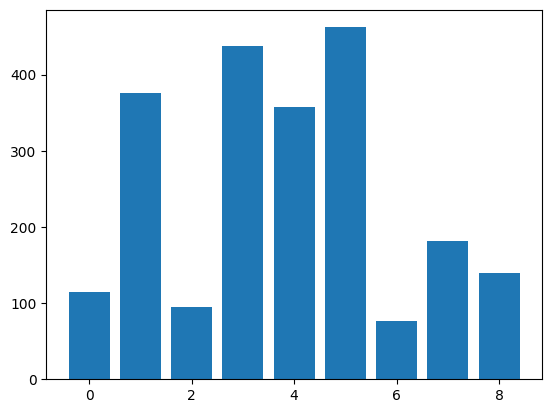

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

* As we can see from the chart above, there is a large data imbalance.
* Class (6) with label 'seborrheic keratosis' has the least number of samples
* Class (5) with label 'pigmented benign keratosis' has the highest number of samples

### 7.1 Use Augmentor to handle data imbalance

In [27]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x75311C7A83A0>: 100%


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x75311C72BB80>: 100%


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x75311C78C940>: 100


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x75312F8B8B80>: 100%


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x75312F8F6140>: 100


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x75311C729120>: 100%


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x75311C65E8C0>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### 7.2 Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### 7.3 Create dataset using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### 7.3.1 Training Dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### 7.3.2 Validation Dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## 8. Build Model_3 with normalization

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 8.1 Compile the model_3

In [39]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 8.2 Train your model_3

In [40]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 15s 66ms/step - loss: 1.8736 - accuracy: 0.2878 - val_loss: 1.4591 - val_accuracy: 0.4417
Epoch 2/50
169/169 [==============================] - 11s 62ms/step - loss: 1.4457 - accuracy: 0.4525 - val_loss: 1.3052 - val_accuracy: 0.5041
Epoch 3/50
169/169 [==============================] - 11s 63ms/step - loss: 1.1989 - accuracy: 0.5466 - val_loss: 1.2763 - val_accuracy: 0.5286
Epoch 4/50
169/169 [==============================] - 11s 63ms/step - loss: 1.0078 - accuracy: 0.6287 - val_loss: 1.1336 - val_accuracy: 0.5724
Epoch 5/50
169/169 [==============================] - 11s 62ms/step - loss: 0.8448 - accuracy: 0.6942 - val_loss: 0.9033 - val_accuracy: 0.6949
Epoch 6/50
169/169 [==============================] - 11s 63ms/step - loss: 0.7256 - accuracy: 0.7368 - val_loss: 0.8646 - val_accuracy: 0.7179
Epoch 7/50
169/169 [==============================] - 11s 63ms/step - loss: 0.5724 - accuracy: 0.7906 - val_loss: 0.7587 - val_accuracy:

#### 8.3  Visualize the model_3 results

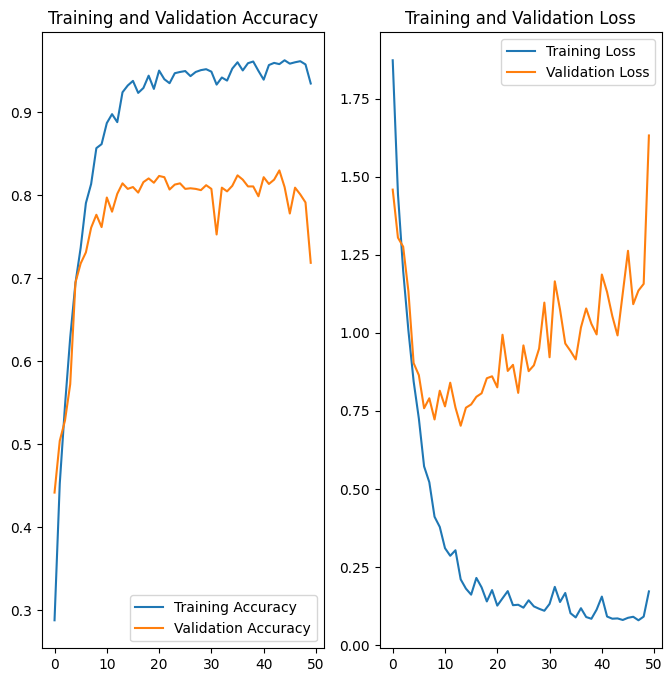

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* After addressing data imbalance and applying normalization during training we can see both training and validation scores improve significantly
* We have used a batch size of 50 and this seems to be a high number for the available data. From the graph the model seems to have learnt the possible best at a batch size of 20. After 40th iteration you could see the loss shooting significantly.
* Lets retrain the model with a batch size of 20 get out final result.

In [42]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 10s 60ms/step - loss: 0.1887 - accuracy: 0.9356 - val_loss: 1.1680 - val_accuracy: 0.7988
Epoch 2/20
169/169 [==============================] - 10s 62ms/step - loss: 0.1008 - accuracy: 0.9570 - val_loss: 1.0921 - val_accuracy: 0.8040
Epoch 3/20
169/169 [==============================] - 11s 62ms/step - loss: 0.0819 - accuracy: 0.9612 - val_loss: 1.1029 - val_accuracy: 0.8226
Epoch 4/20
169/169 [==============================] - 10s 62ms/step - loss: 0.0815 - accuracy: 0.9605 - val_loss: 1.0263 - val_accuracy: 0.8099
Epoch 5/20
169/169 [==============================] - 10s 62ms/step - loss: 0.0783 - accuracy: 0.9629 - val_loss: 1.1157 - val_accuracy: 0.8025
Epoch 6/20
169/169 [==============================] - 10s 62ms/step - loss: 0.0778 - accuracy: 0.9644 - val_loss: 1.0671 - val_accuracy: 0.8092
Epoch 7/20
169/169 [==============================] - 11s 65ms/step - loss: 0.1310 - accuracy: 0.9473 - val_loss: 1.3048 - val_accuracy:

## 9. Final Score
* We finally get a training acc of 96% and a validation accuracy of 81%

## 10. Model Prediction

Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/*
1/1 [==============================] - 0s 12ms/step
[[-4.742163  10.353453  -3.0338516 -6.8475485 -5.543365   4.5750036
  -3.6975899 -5.622597  -3.4097078]]
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


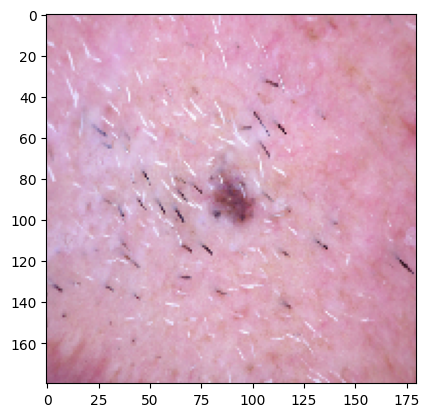

In [67]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
print(Test_image_path)
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
print(pred)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

* We are able to predict the class successfully 